In [13]:
#Cargar deendencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#carga transitorios de calcio
df=pd.read_csv('/content/drive/MyDrive/Python/Calcio/Shank3_IGF/L1_988_directions_C_traces2.csv')
df.drop(df.columns[0], axis=1, inplace=True) # Elimina la columna 'Time'
#Carga time stamps de los estimulos
data = np.load(r'/content/drive/MyDrive/Python/Calcio/Shank3_IGF/L1_988_result.npy')

# Supongamos que df es tu DataFrame con las señales de las neuronas
# y data es tu matriz de datos de forma (13, 8, 2)

# Parámetros
sampling_rate = 5  # 5 Hz
frames_before = 2 * sampling_rate  # 2 segundos antes
frames_after = 4 * sampling_rate  # 4 segundos después
total_frames = frames_before + frames_after  # Total de frames a extraer

# Diccionario para almacenar los datos
extracted_data = {}

# Iterar sobre la matriz de datos
for stimulus_type in range(data.shape[0]):
    for trial in range(data.shape[1]):
        angle = int(data[stimulus_type, trial, 0])  # Ángulo del estímulo
        stimulus_frame = int(data[stimulus_type, trial, 1])  # Frame en el que se presentó el estímulo

        # Calcular los frames a extraer
        start_frame = stimulus_frame - frames_before
        end_frame = stimulus_frame + frames_after

        # Extraer los frames del DataFrame
        F = df.iloc[start_frame:end_frame, :].values

        # Normalizacion dF/F
        F0 = np.median(F[0:frames_before])
        extracted_signal = (F-F0)/F0

        # Si el ángulo no está en el diccionario, lo añadimos
        if angle not in extracted_data:
            extracted_data[angle] = []

        # Añadir la señal extraída al diccionario
        extracted_data[angle].append(extracted_signal)

# Convertir las listas en matrices numpy
for angle in extracted_data:
    extracted_data[angle] = np.stack(extracted_data[angle], axis=-1)
    extracted_data[angle] = np.transpose(extracted_data[angle], (1, 0, 2))

# Ahora extracted_data es un diccionario donde cada clave es un ángulo
# y cada valor es una matriz de forma (N, T, Ensayo)

In [15]:
#Calcular Neuronas moduladas/responsivas
responsive_neurons = []

#looping sobre todos los angulos
for neuron in range(extracted_data[0].shape[0]):
#Identificar neuronas moduladas
  for angle in extracted_data:
     neuron_theta = extracted_data[angle][neuron,:,:]
     threshold = np.std(neuron_theta[0:10])*3
     angle_response = np.mean(neuron_theta[10:30])
     responsivenes = angle_response > threshold
    #Guarda la identidad de las neuronas responsivas
     if responsivenes == True and neuron not in responsive_neurons:
       responsive_neurons.append(neuron)

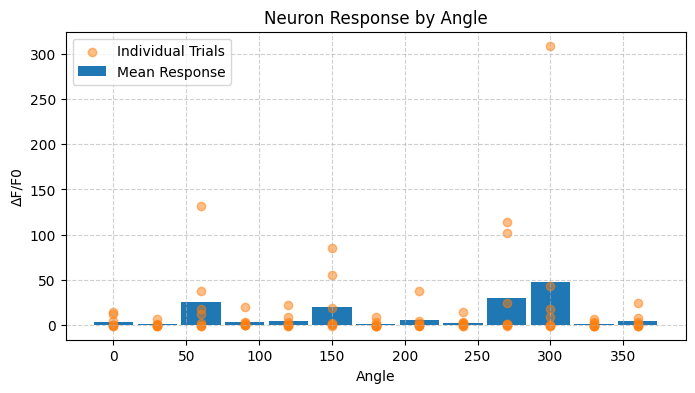

In [16]:
# Select a specific neuron
neurona = responsive_neurons[1]

# Initialize lists to store responses and angles
neuron_responses_df_f = []
neuron_responses_angles = []

# Calculate mean response for each angle
for angle in extracted_data:
    neuron_theta = extracted_data[angle][neurona, :, :]  # Select the specific neuron
    angle_response = np.mean(neuron_theta[10:30, :], axis=0)  # Average over time
    neuron_responses_df_f.append(angle_response)  # Append the mean response
    neuron_responses_angles.extend([angle] * angle_response.size)  # Append the corresponding angle for each trial

# Combine responses into a single array
neuron_responses_df_f = np.concatenate(neuron_responses_df_f)
# Create a DataFrame
df = pd.DataFrame({'angle': neuron_responses_angles, 'dF/F': neuron_responses_df_f})
# Group by angle and calculate the mean of dF/F
grouped = df.groupby('angle')['dF/F'].mean().reset_index()

# Plot the bar plot and scatter plot
plt.figure(figsize=(8, 4))
plt.bar(grouped['angle'], grouped['dF/F'], width=27, label='Mean Response')
plt.scatter(neuron_responses_angles, neuron_responses_df_f, alpha=0.5, label='Individual Trials')
plt.xlabel('Angle')
plt.ylabel('ΔF/F0')
plt.title('Neuron Response by Angle')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


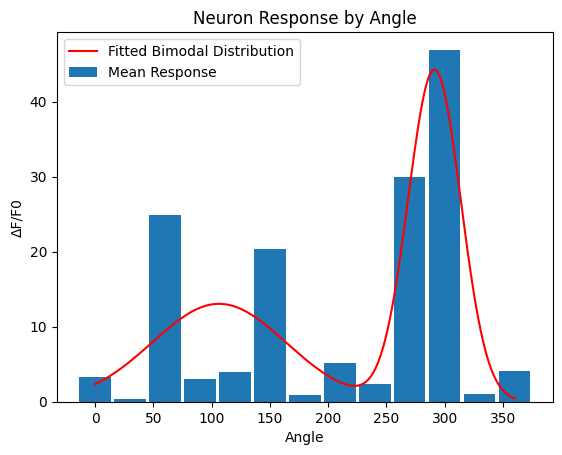

In [17]:
# Create a distribution to fit the GMM
bin_width = 30
distribution_df_f = []
angle_bins = list(extracted_data.keys())
for angle in range(len(grouped['dF/F'])):
    bins = list(map(int, angle_bins))
    bin_angle = bins[angle]  # Get the bin value
    count = np.round(grouped['dF/F'][angle])    # Get the count for this bin
    ocurrences = np.max([1,int(count)])
    distribution_df_f.extend([bin_angle] * ocurrences)  # Repeat the bin value 'count' times

# Fitting the GMM
gmm = GaussianMixture(n_components=2)
gmm.fit(np.array(distribution_df_f).reshape(-1, 1))  # Reshape data for GMM
theta = np.linspace(0, 360, 360)
pdf = np.exp(gmm.score_samples(theta.reshape(-1, 1)))
pdf = pdf*len(distribution_df_f)*bin_width

# Plotting
plt.bar(grouped['angle'], grouped['dF/F'], width=27, label='Mean Response')
plt.plot(theta, pdf, 'r-', label="Fitted Bimodal Distribution")
plt.xlabel('Angle')
plt.ylabel('ΔF/F0')
plt.title('Neuron Response by Angle')
plt.legend()

In [18]:
# Calcular el OSI
r_pref = np.max(pdf)
thetha_pref = np.argmax(pdf)
thetha_orto = thetha_pref+90 if thetha_pref+90 < 360 else thetha_pref-90
r_orto = pdf[thetha_orto]

# OSI
OSI = (r_pref-r_orto)/(r_pref+r_orto)
print(OSI)

0.8577468429670866


In [19]:
# Initialize a list to store OSI values for all neurons
osi_values = []

# Iterate over all responsive neurons using their original indices
for neurona in responsive_neurons:
    # Initialize lists to store responses and angles
    neuron_responses_df_f = []
    neuron_responses_angles = []

    # Calculate mean response for each angle
    for angle in extracted_data:
        neuron_theta = extracted_data[angle][neurona, :, :]  # Select the specific neuron
        angle_response = np.mean(neuron_theta[10:30, :], axis=0)  # Average over time
        neuron_responses_df_f.append(angle_response)  # Append the mean response
        neuron_responses_angles.extend([angle] * angle_response.size)  # Append the corresponding angle for each trial

    # Combine responses into a single array
    neuron_responses_df_f = np.concatenate(neuron_responses_df_f)

    # Create a DataFrame
    df = pd.DataFrame({'angle': neuron_responses_angles, 'dF/F': neuron_responses_df_f})

    # Group by angle and calculate the mean of dF/F
    grouped = df.groupby('angle')['dF/F'].mean().reset_index()

    # Create a distribution to fit the GMM
    bin_width = 30
    distribution_df_f = []
    angle_bins = list(extracted_data.keys())
    for angle in range(len(grouped['dF/F'])):
        bins = list(map(int, angle_bins))
        bin_angle = bins[angle]  # Get the bin value
        count = np.round(grouped['dF/F'][angle])    # Get the count for this bin
        ocurrences = np.max([1, int(count)])
        distribution_df_f.extend([bin_angle] * ocurrences)  # Repeat the bin value 'count' times

    # Fitting the GMM
    gmm = GaussianMixture(n_components=2)
    gmm.fit(np.array(distribution_df_f).reshape(-1, 1))  # Reshape data for GMM
    theta = np.linspace(0, 360, 360)
    pdf = np.exp(gmm.score_samples(theta.reshape(-1, 1)))
    pdf = pdf * len(distribution_df_f) * bin_width

    # Calcular el OSI
    r_pref = np.max(pdf)
    thetha_pref = np.argmax(pdf)
    thetha_orto = thetha_pref + 90 if thetha_pref + 90 < 360 else thetha_pref - 90
    r_orto = pdf[thetha_orto]

    # OSI
    OSI = (r_pref - r_orto) / (r_pref + r_orto)
    osi_values.append(OSI)

# Create a DataFrame with the original neuron indices and OSI values
osi_df = pd.DataFrame({'Neuron': responsive_neurons, 'OSI': osi_values})

# Save the DataFrame to a CSV file
osi_df.to_csv('osi_values.csv', index=False)

In [20]:
osi_df

,Neuron,OSI
0,0,0.992807
1,5,0.857747
2,12,0.272318
3,15,0.586552
4,16,0.450001
5,17,0.566795
6,18,0.359532
7,26,0.958557
8,28,0.916466
9,29,0.305587
